# Mike IMC Pipeline v0.1 - 8th September 2022
#### <font color='blue'>This is a work in progress, and should be treated as such. Expect errors and issues! The start should hopefully be fairly 'one size fits all', but as it progresses it gets more and more complex, and will require an increasing knowledge of Python or more customisation to run: </font>

### <font color='green'>Green</font> - Should run with only minor or no changes at all
### <font color='orange'>Orange</font> - Requires a fair amount of customisation, and usually adding in external files (e.g. images or extra .csv files)
### <font color='red'>Red</font> - Currently not well annotated and/or very complex code

Developed by Michael Haley (michael.haley@manchester.ac.uk), **please do not share publicly!!**


## <font color='red'>Setting up Python</font>

### 1. Setting up Anaconda
If you haven't yet setup Anaconda on your system, and are viewing this on the Github, there first step is to install and setup **Anaconda** (https://www.anaconda.com/products/distribution)


### 2. Setting up the environment
Once Anaconda is installed, we need to open the Anaconda Powershell Prompt, and create a new environment which we will call IMC (you can call it anything) using Conda. 
>**conda create --name IMC**</br>

We then want to add some channels to Conda where packages will be downloaded from
>**conda config --add channels conda-forge bioconda**</br>

We now activate our new environment, and then start installing the packages we will need. This could take a while!
>**conda install squidpy scanpy pandas anndata seaborn yaml scikit-image yellowbrick dill umap-learn napari-imc colorcet scikit-learn jupyterlab shapely tqdm git**
</br>

Some packages aren't available on Conda, and therefore need to be installed via Pip
>**pip install ai4scr-spatial-omics ai4scr-athena phenograph**</br>

### 3. Starting Jupyter
Download this notebook and the **'mikeimc_v2.py'** place them somewhere sensible (e.g. 'C:/Programming', or wherever)

Open Anaconda Powershell and change directories to where you have put the downloaded files. In the above example...
>**cd c:/programming**

Activate the IMC environment. You can tell what environment you are currently in by looking at the start of the command line by default it will be *(base)*, after this is should be *(IMC)*

>**conda activate IMC**

Start Jupyter notebook
>**jupyter notebook**

Open up the Jupyter notebook, and contine below...

## <a id="celltable"><font color='red'>Cleaning up the cell table</font></a>

This pipeline assumes you have already segmented your data to get single-cell data, and have a **cell table** for your data (see example in image below). This is simply a spreadsheet (.csv format) in which each cell is one row, and information about that cell in columns - usually marker expression and X and Y location in the image, but could also be other information such as cell size.

You will want to clean up your cell table first in Excel. The output of most segmentation pipelines give you a *huge* cell table, with loads of extra information you probably dont need.

The minimum columns you need are:

- 1 column called **'ROI'** that identifies the image where the cells came from

- **1 column *per* marker**, which should be the mean intensity of that marker, with an easily identifiable name

- 1 column for **X location** of cell

- 1 column for **Y location** of cell

## <font color='red'>Creating the accompanying files</font>
Create (or modify using the templates) **columns.csv** and **dictionary.csv** files as detailed in the below schematic.

Save them in the save folder as the Jupyter notebook.

<img src="celltable.jpg" />

%%html
<img src="celltable.jpg">

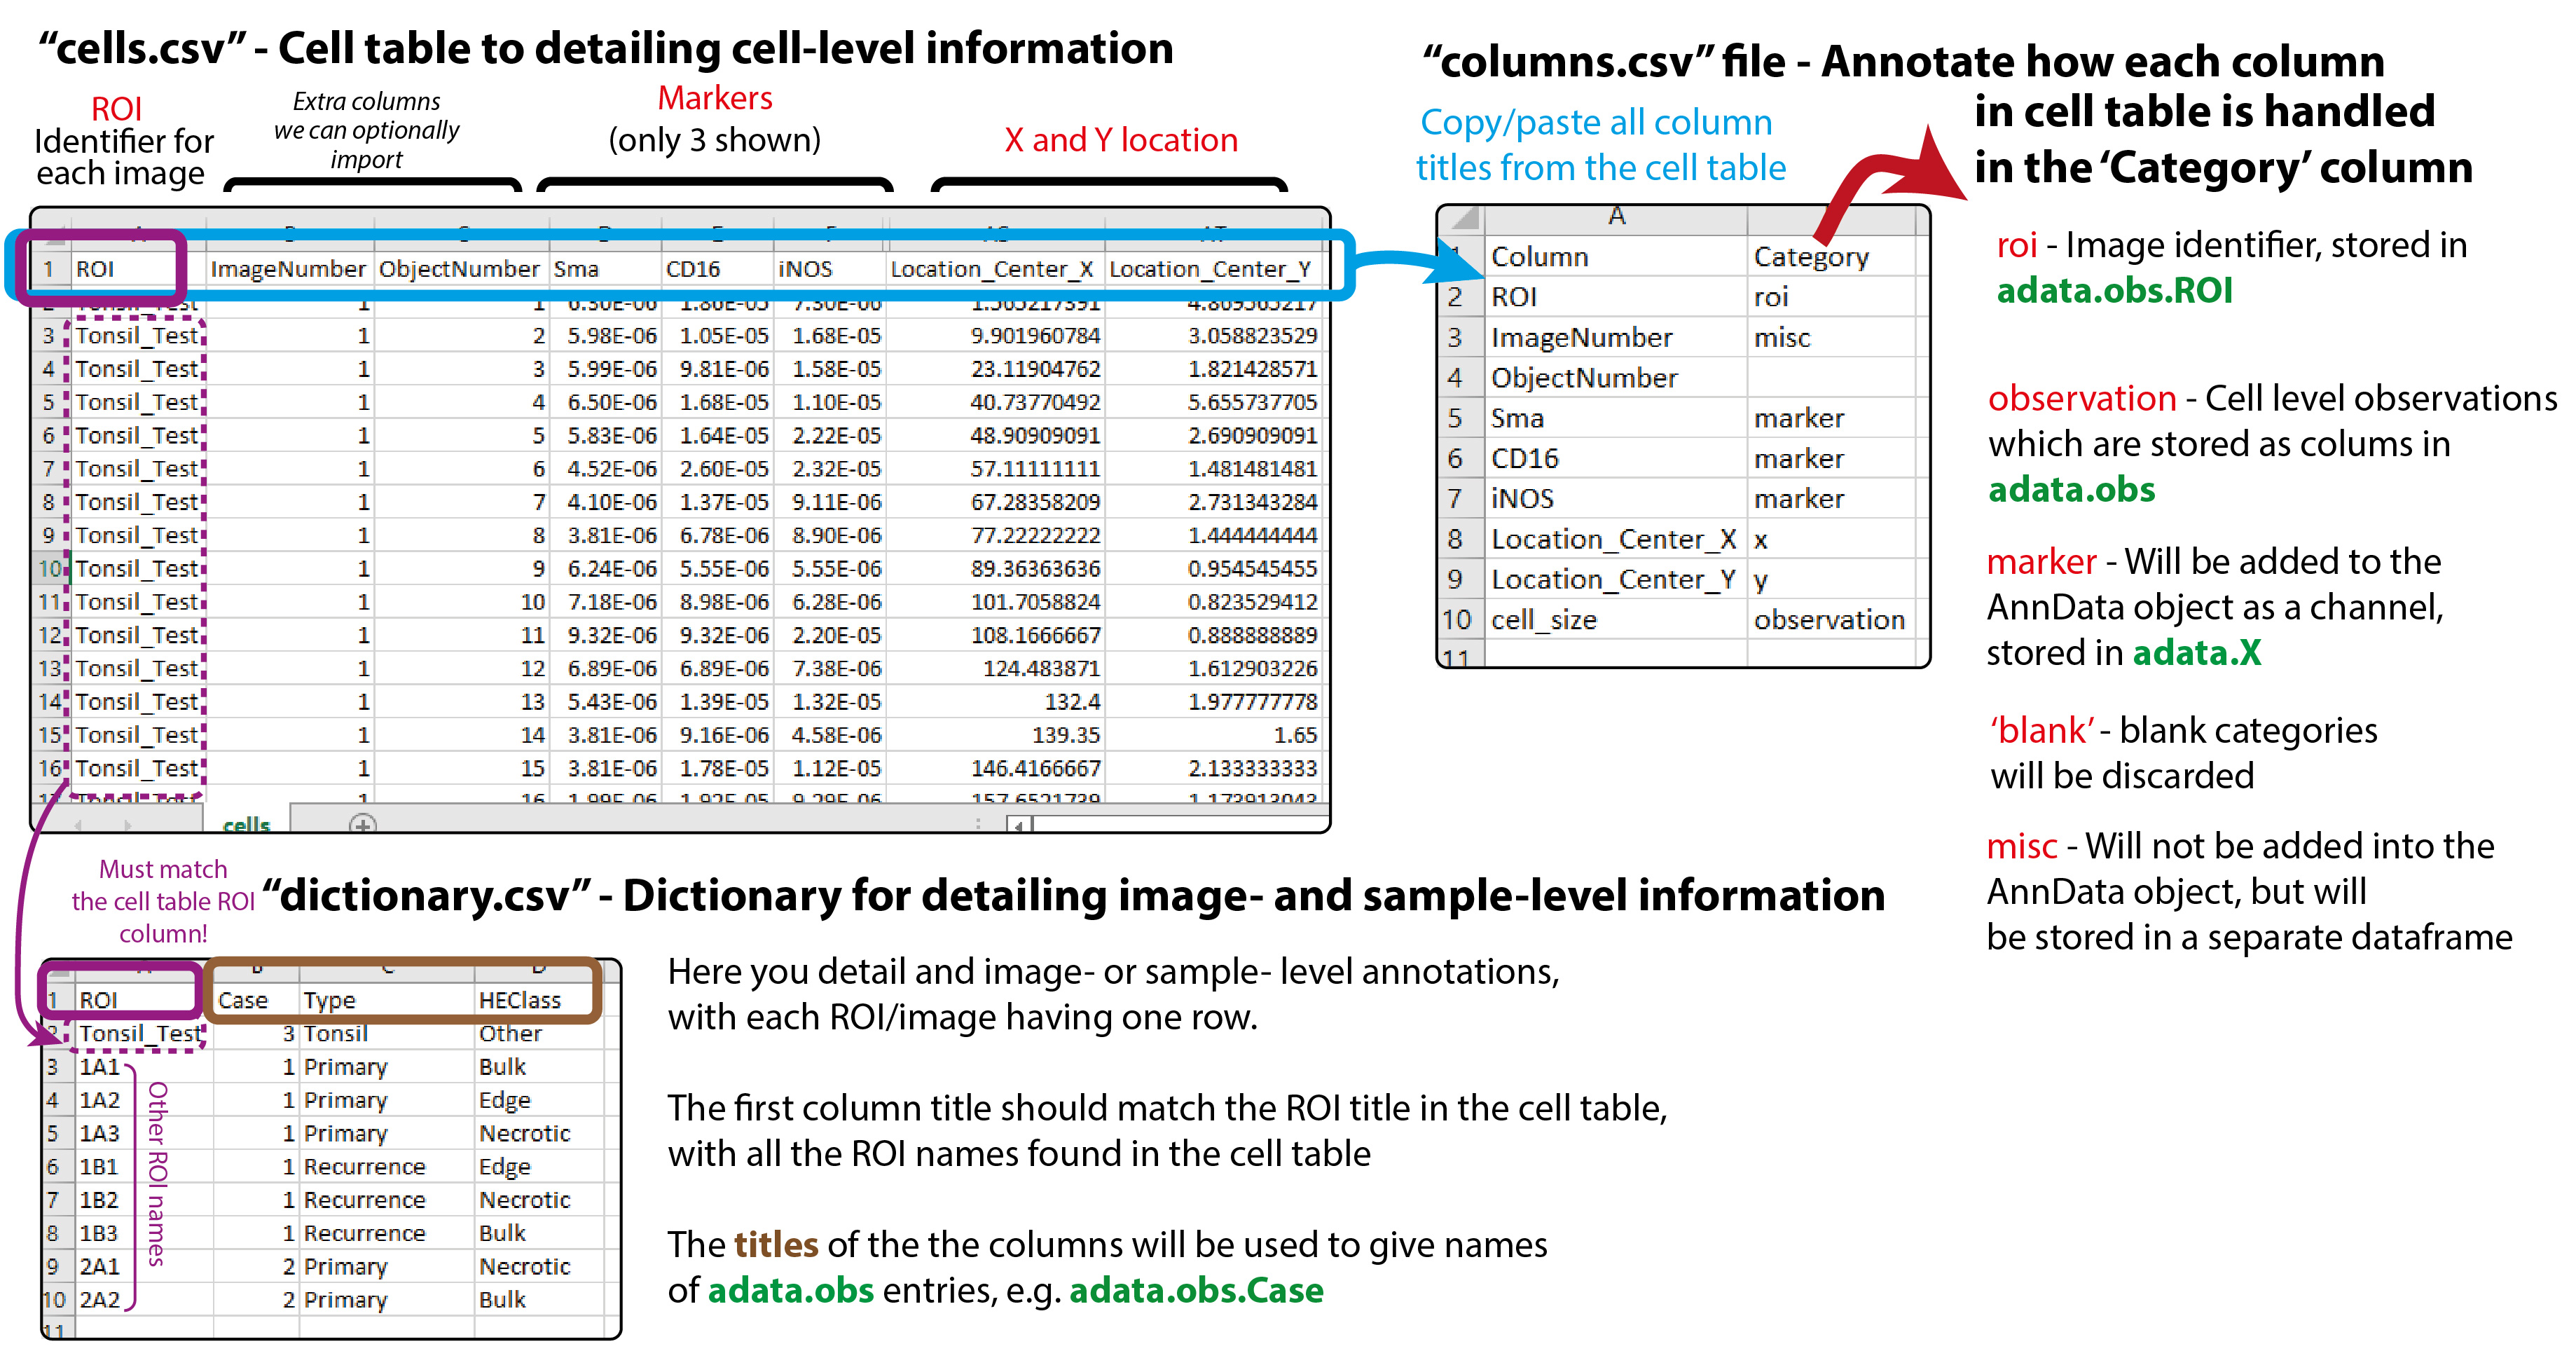

In [44]:
from IPython.display import Image
Image("celltable.jpg")

## <font color='red'>Important notes on using this pipeline</font>
When we do analyses in Python, it is important to understand *where* and *how* our data is being stored. Simply, there are 3 different places that our analyses may exist, potentially all at the same time:

*Data and analyes may be stored in....*

#### The Python kernel
This is the instance of Python that you are currrently working in. It has all the variables and objects you have currently defined stored in the memory, allowing us to access and work with them. However, if we close the kernel, or it crashes, **we lose all our analyses!** Usually we can just re-run all the analyses again without an issue, but it's time consuming and annoying. If the browser crashes, that is not an issue - just reopen the browser,  go back to the Jupyter web page (look in your browser 'history' to find the address), and you should be able to pick up where you left off. However, in order to keep Jupyter and the kernel running, do not close the Anaconda prompt you used to start Jupyter, or turn off your computer

#### The Jupyter notebook file (.ipynb)
This stores all your **markdown, code and the outputs** of any analyses you have run - essentially, **if you can see it visually on screen it will be saved in the Jupyter notebook file!**. Jupyter will automaticlaly save periodically. However, if you rerun cells, you lose any previous outputs, unless you have saved them to disk...

#### Exported / saved figures
The safest way to store your analyses and export them out of Python is to store the resulting figures to disk as images, or export any tabular data as spread sheets. 

#### Adata object saved on disk
You can save AnnData (*adata*) objects to disk, and reload them later. This is the a very convenient way to come back to later analyses. Unfortunately, there is no good way to save spatial-omics *so* objects.

<div class="alert alert-block alert-danger">
Do not close the Anaconda Powershell you used to start Jupyter, turn off your computer entirely, or manually restart the kernel <b>unless</b> you have saved your analyses somehow, or don't mind rerunning your analyses (which in some cases may take several hours!)
</div>

# <font color='green'> Import libraries and setup </font>

<div class="alert alert-block alert-info">
<b>Read the package documentation!</b> I'm not going to give an extended explanation of how the various packages work. Instead, go and read the documentation and papers associated with the main packages I have linked here. This will explain how the different functions work, give worked examples, and explain how you can customise the code. 
</div>

This will import the libraries that we need, including a module I've made called **'mikeimc'** which has some useful functions for processing IMC data - *mikeimc_v2.py* should the in the same directory as this notebook. The other libraries should already be installed if you have setup the environment correctly, if not they won't import here and you will get an error.

### Packages:

##### Scanpy
Single-cell analysis developed for single-cell sequencing, but also works great for IMC.
https://scanpy.readthedocs.io/en/stable/

##### Squidpy
Built on scanpy, expands to do several different spatial analyses
https://squidpy.readthedocs.io/en/stable/
https://www.biorxiv.org/content/10.1101/2021.02.19.431994v1

##### AnnData
Data object used to store all our single cell analyses (in the *adata* object)
https://anndata.readthedocs.io/en/latest/

##### Pandas
Tools for working with tables of data, which is pretty much all the data we will be working with.

##### BBKNN:
Algorithm implemented by Scanpy to do batch correction
https://academic.oup.com/bioinformatics/article/36/3/964/5545955

##### ATHENA and 'spatial omics' object
Developed by a former member of the Bodemiller lab, has a lot more functionality to do in-depth spatial analyses. The problem is that it isn't build directly on an *adata* object, instead using an *so* (spatial omics) object. Therefore, we have to transer all the data from the *adata* to the *so* half way through.

https://github.com/AI4SCR/ATHENA
https://github.com/AI4SCR/spatial-omics
https://histocartography.github.io/athena/index.html


<div class="alert alert-block alert-danger">
<b>CaseViewer/3DHistech Issue</b> If you are having an error where Jupyter crashes and you have CaseViewer or some other 3D Histech software installed, it could be because of the following issue:
https://github.com/lmcinnes/umap/issues/702
</div>

In [ ]:
# Standard libraries for data analysis, most of these should be automatically installed
import numpy as np
import scipy as sp

# Pandas for working with dataframes and tabular data
import pandas as pd

# AnnData for working with anndatas (annotated datas)
import anndata as ad

# Matplotlib and seaborn for plotting
import matplotlib
from matplotlib import rcParams
from matplotlib import colors
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sb

# For access to good colour maps
import colorcet as cc

# OS and pathlib for opening/deleting files
import os
from pathlib import Path

# Scanpy 
import scanpy as sc
import scanpy.external as sce

# Squidpy
import squidpy as sq

#Packages to do Elbow analysis
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Import UMAP
# This can cause a crash if CaseViewer is installed! See comment above.
import umap 

#My module for importing IMC data into AnnData format
import mikeimc_v2
import mikeimc_v2 as mimc

#To display multiple dataframes in same output
from IPython.display import display

#ATHENA
from spatialOmics import SpatialOmics
import athena as sh

#Loading bar functionality for long tasks
from tqdm import tqdm

#For multiprocessing
from functools import partial
from multiprocessing import Pool

#### Reload mikeimc

In [ ]:
import mikeimc_v2
import imp
imp.reload(mikeimc_v2)

#### Setup or reset default parameters for plotting

<div class="alert alert-block alert-info">
    <b>Tip</b> Re-run this cell if your plots start looking weird and you're not sure why! 
</div>

In [ ]:
# Reset plotting parameters to their defaults
matplotlib.pyplot.rcParams.update(matplotlib.rcParamsDefault)

# Set up output figure settings
plt.rcParams['figure.figsize']=(5,5) #rescale figures, increase sizehere

# Set up scanpy settings
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, dpi_save=200) #Increase DPI for better resolution figures

# <font color='green'> Saving / loading adata objects </font>
These don't need to be run initially, but will be useful to save and load analyses, or export data to a spreadsheet for external analyses.

<div class="alert alert-block alert-danger">
    <b>Be careful using save and load!</b> There will be no warning if you overwrite the wrong file, or load in an empty adata and therefore lose the one you're working on!
</div>

#### Save adata object
This will save the adata object in the current directory as a file called 'adata'

In [ ]:
adata.write('adata')

#### Export cell table
This will export the currently adata.obs, which will give you a table format of all your cells, what populations and results of several key analyses.

In [ ]:
adata.obs.to_csv('adata_obs.csv')

#### Load adata
This will open up a stored adata object (from the 'raw' directory)

In [ ]:
adata = ad.read_h5ad('adata')

# <font color='green'> Importing raw data (*cell table*, *column* and *dictionary* .csv files) into the adata object</font>

#### Import cell data from .csv files
[See above for an explanation of how data should be layed out for importing](#celltable)

In [ ]:
adata_fullimport, df_misc = mimc.celltable_to_adata(column_properties='raw/columns.csv', #Contents define how the columns in the cell table should be handled
                                                cell_table='raw/cells.csv', #The full cell table as exported by whatever cell segmentation pipeline
                                                dictionary='raw/dictionary.csv', #If this is specified, it will add extra observations based upon the ROI, e.g. what group/patient/treatment it came from
                                                marker_normalisation='99th', #Marker normalisation, by default will be None
                                                misc_table=True) #Whether or not a second dataframe of 'misc' findings will be imported

#### Check AnnData import was worked as expected
Check that all the variables (markers) are listed here, as well as any obserations under 'obs'

In [ ]:
# Print a list of the variables imported
print(adata_fullimport.var_names)

# Print the structure of the AnnData
print(adata_fullimport)

#### Removing markers and non-primary samples to make the working AnnData

Use this code to remove any markers or samples which you don't want included in your final adata that you'll be using for analyses

In [ ]:
adata = mimc.filter_anndata(adata_source=adata_fullimport,
                            markers_to_remove=['DNA1', 'DNA3','PanCytokeratin','iNOS'], #List of markers to remove, e.g, DNA markers
                            obs_to_filter_on='ROI', #The .obs category which you want to filter on
                            obs_to_remove=['Tonsil_Test','BrainCtrl','2A3_Test','Tonsil']) #The types of .obs you want removing, e.g. test ROIs

# Only work with primary tumours
adata = adata[adata.obs['Type']=='Primary'].copy()

# Print a list of the variables that appear in the working anndata
print(adata.var_names)

# Print the structure of the working anndata
print(adata)

#### Convert some columns to category
This will save headaches in later stages - makes sure that all categorical variables in obs are stored as categories

In [ ]:
# This will list out the columns you may want to now convert...
adata.obs.columns.tolist()

In [ ]:
# Alter this with the categorical obs from above
for i in ['ROI','Case','Type','HEClass','HEClass_2class','HEClass_3class','HEClass_niches']:
    adata.obs[i]=adata.obs[i].astype('category')

#### Very quick QC check of data
Some simple QC checks - look at expression of all the markers in each ROI in a heatmap

In [ ]:
# The title of  the column in which defines each image/region of interest
image_var = 'ROI'

# Plot a heat of all the markers
sc.pl.matrixplot(adata, adata.var_names, groupby=image_var)

# <font color='green'> Batch integration using BBKNN </font>
This will batch correct using BBKNN. There are other options batch correction, such as Harmony, but I found this the easiest to implement. Read more here: https://bodenmillergroup.github.io/IMCDataAnalysis/batch-effects.html

#### Run PCA and BBKNN

In [ ]:
# Define the number of PCA dimensions to work with - one less than number of markers. Without this, it usually defaults to 50, which we don't have enough markers for.
n_for_pca = len(adata.var_names)-1

# Define the 'obs' which defines the different cases
batch_correction_obs = 'Case'

# Calculate PCA, this must be done before BBKNN
sc.tl.pca(adata, n_comps=n_for_pca)

# BBKNN - it is used in place of the scanpy 'neighbors' command that calculates nearest neighbours in the feature space
sc.external.pp.bbknn(adata, batch_key='Case', n_pcs=n_for_pca)

# <font color='green'> UMAPS</font>

#### Calculate UMAP

In [ ]:
sc.tl.umap(adata)

#### Plot UMAPs

In [ ]:
#Define a list of .obs to colour the UMAP by
UMAP_groups = ['Case','ROI', 'HEClass_2class', 'HEClass_3class', 'HEClass_niches'] 

# Plot UMAPs coloured by list above
sc.pl.umap(adata, color=UMAP_groups, ncols=1, size=3)

# This will plot a UMAP for each of the individual markers
sc.pl.umap(adata, color=adata.var_names.tolist(), color_map='plasma', ncols=4, size=3)

# <font color='green'> Population identification</font>

## Initial population identification using Leiden clustering
This is the same algorithm used by PhenoGraph, and is more or less the same

#### Initial Leiden clustering

In [ ]:
# Change this to alter the size of the clusters - small resolution results in bigger clusters (therefore, less clusters overall, but each with more cells)
resolution = 1
leiden_obs_name = 'leiden_'+str(resolution)

# This will perform the clustering, then add an 'obs' with name specified above, e.g leiden_0.35
sc.tl.leiden(adata, resolution=resolution, key_added = leiden_obs_name) 

#### Plot initial clustering results

In [ ]:
image_var = 'ROI' # The adata.obs that defines each image or ROI

sc.set_figure_params(figsize=(5, 5))
sc.pl.umap(adata, color=leiden_obs_name,size=2)

# Plot a heatmap
sc.pl.matrixplot(adata,
                 adata.var_names.tolist(), 
                 groupby=leiden_obs_name, 
                var_group_rotation = 0,
                vmax=0.6,
                dendrogram=True)

# Alter this list with adata.obs variables that you want to plot against the resulting leiden population
for i in ['Case']:

    mikeimc_v2.grouped_graph(adata,
                             ROI_id=image_var,
                             group_by_obs=i,
                             x_axis=leiden_obs_name,
                             fig_size=(10,3),
                             log_scale=True,
                            display_tables=False) #If you change display_tables to True, will also do stats on the groups
    plt.show()

#### Sub clustering example
Once you've done the initital subclustering, which could be with a fairly low resolution, you can then do subclustering on specific clusters from previous Leiden analyses

In [ ]:
# Change this to alter the size of the clusters in the subclustering
resolution = 0.2
leiden_obs_name = 'leiden_'+str(resolution)

# In the following example, it will do a leiden clustering based upon the the results of 'leiden_1', selecting population 2
sc.tl.leiden(adata, resolution=resolution, key_added = leiden_obs_name, restrict_to=('leiden_1',['2'])) 

#### Plot final clustering results

In [ ]:
image_var = 'ROI' # The adata.obs that defines each image or ROI

sc.set_figure_params(figsize=(5, 5))
sc.pl.umap(adata, color=leiden_obs_name,size=2)

# Plot a heatmap
sc.pl.matrixplot(adata,
                 adata.var_names.tolist(), 
                 groupby=leiden_obs_name, 
                var_group_rotation = 0,
                vmax=0.6,
                dendrogram=True)

# Alter this list with adata.obs variables that you want to plot against the resulting leiden population
for i in ['Case']:

    mikeimc_v2.grouped_graph(adata,
                             ROI_id=image_var,
                             group_by_obs=i,
                             x_axis=leiden_obs_name,
                             fig_size=(10,3),
                             log_scale=True,
                            display_tables=False) #If you change display_tables to True, will also do stats on the groups
    plt.show()

## Label final populations

#### Remapping populations
Here we are creating 'dictionaries' that will remap the population numbers from the Leiden clustering, to actual names.

I've usually been working with 3 different labels.  
**populations** - This is the exact population name for that Leiden population. If you give two numbers the same name, they will be combined (e.g. 10 and 14 below).

**hierarchy** - This gives a more broad hierarchy for the populations, allowing us to specicfy analyses only be done on certain cell types.

**populations_broad** - This is a combination of populations and hierarchy, and what I've mostly used in subsequent analyses. For my analyses that mostly focused on myeloid cells, I decided to combine all the different tumour types into one label ('Tumour'), but still keep all the myeloid populations.

In [ ]:
leiden_obs_name = 'leiden_final'

populations={'0':'Tumour, Sox2+Nestin+',
'1':'Tumour,  Cd44+S100B+',
'2':'TAM/Micro intermediate',
'3':'Tumour, Sox2+Olig2+',
'4':'Tumour, Cd44+',
'5':'Tumour, Sox2+',
'6':'Tumour, Cd44+GFAP+Vimentin+',
'7':'Tumour, GLUT1+',
'8':'Tumour, pERK+',
'9':'Stroma',
'10':'Stroma',
'11':'Astrocytes',
'12':'Microglia, resting',
'13':'Vascular',
'14':'Stroma',
'15':'Tumour, Sox2+',
'16,0':'TAMs, Cd206+',
'16,1':'TAMs, Cd74+VISTA+',
'17':'Tumour, Sox2+Nestin+Ki67+',
'18,0':'Microglia, Cd16+VISTA+',
'18,1':'Microglia',
'19':'Vascular',
'20':'Tumour, Cd44+',
'21':'Myeloid, Cd68+',
'22':'Immune, HIF1a+',
'23':'Cd8 lymphocytes'
}

hierarchy={'0':'Tumour',
'1':'Tumour',
'2':'Myeloid',
'3':'Tumour',
'4':'Tumour',
'5':'Tumour',
'6':'Tumour',
'7':'Tumour',
'8':'Tumour',
'9':'Stroma',
'10':'Stroma',
'11':'Stroma',
'12':'Myeloid',
'13':'Vascular',
'14':'Stroma',
'15':'Tumour',
'16,0':'Myeloid',
'16,1':'Myeloid',
'17':'Tumour',
'18,0':'Myeloid',
'18,1':'Myeloid',
'19':'Vascular',
'20':'Tumour',
'21':'Myeloid',
'22':'Immune',
'23':'Lymphocytes'
}

population_broad={
'0':'Tumour',
'1':'Tumour',
'2':'TAM/Micro intermediate',
'3':'Tumour',
'4':'Tumour',
'5':'Tumour',
'6':'Tumour',
'7':'Tumour',
'8':'Tumour',
'9':'Stroma',
'10':'Stroma',
'11':'Stroma',
'12':'Microglia, resting',
'13':'Vascular',
'14':'Stroma',
'15':'Tumour',
'16,0':'TAMs, Cd206+',
'16,1':'TAMs, Cd74+VISTA+',
'17':'Tumour',
'18,0':'Microglia, Cd16+VISTA+',
'18,1':'Microglia',
'19':'Vascular',
'20':'Tumour',
'21':'Myeloid, Cd68+',
'22':'Immune, HIF1a+',
'23':'Cd8 lymphocytes'
}    
    
adata.obs['population']=adata.obs[leiden_obs_name].map(populations).astype('category')
adata.obs['population_broad']=adata.obs[leiden_obs_name].map(population_broad).astype('category')
adata.obs['hierarchy']=adata.obs[leiden_obs_name].map(hierarchy).astype('category')

#### Plotting final populations with new names

In [ ]:
for i in ['population','population_broad','hierarchy']:
    sc.set_figure_params(figsize=(5, 5), dpi=200)
    sc.pl.umap(adata, color=i,size=2)
        
    sc.pl.matrixplot(adata,
                     adata.var_names, 
                     groupby=i, 
                    var_group_rotation = 0,
                    vmax=0.7,
                    dendrogram=True)

# <font color='green'> Spatial mapping of cells</font>
Cell populations can be spatially plotted using a couple of different ways. In this example, we just express cells as dots.

In [ ]:
sb.set_style("whitegrid", {'axes.grid' : False})

graph = sb.lmplot(data = adata.obs,
                  x = 'X_loc',
                  y='Y_loc',
                  hue='population_broad', #This is the adata.obs that you want to plot
                  height = 4,
                  col = 'ROI',
                  col_wrap = 3,
                  fit_reg = False,
                  aspect=1,
                  scatter_kws={"s": 5})
#graph.savefig("figures/MappedPlots"+a+".png")    
plt.show()

# <font color='orange'> ATHENA setup</font>
**<font color='red'>This section will need editing depending how your data is layed out, carefully read and alter as appropriate, and will need you to create some folders and files to use masks</font>**

This will transfer the Adata into ATHENA for more complex spatial analyses

#### Transfer data into ATHENA format ('so' object)

Make a copy of the adata to import

In [ ]:
ad = adata.copy()

Add a cell_index - numbers each cell in each sample (starting again at 0 for each sample)

In [ ]:
for roi in ad.obs.ROI.cat.categories:
    ad.obs.loc[ad.obs.ROI==roi,'cell_id'] = ad.obs.loc[ad.obs.ROI==roi,'Master_Index'] - ad.obs.loc[ad.obs.ROI==roi,'Master_Index'].min() + 1

Convert the group names into ids - numbers for each group. This is required for some of athenas plotting functions. Here, we just convert each group name into a number.

In [ ]:
ad.obs['hierarchy_id'] = ad.obs.groupby('hierarchy').ngroup()
ad.obs['population_id'] = ad.obs.groupby('population').ngroup()
ad.obs['population_broad_id'] = ad.obs.groupby('population_broad').ngroup()

Make sure the columns are set to 'category' type, to enable correct plotting. 

In [ ]:
ad.obs.columns

In [ ]:
for i in ['ROI', 'Case', 'hierarchy_id', 'population_id','population_broad_id']:
    ad.obs.loc[:, i] = ad.obs[i].astype('category')

#### Construct the SpatialOmics object

We need to create a new data frame that containts the 'sample level' meta data, these are currently stored in the adata.obs

In [ ]:
spl = ad.obs[['Case', 'ROI', 'Type']]  #These are the sample level obs in the adata
spl = spl[~spl.duplicated()]
spl.set_index('ROI', inplace=True) #Set the index as ROI, which is the unique ID for each region

If you use the Bodenmiller pipeline, the masks are created in the 'CP_Output' folder. Unfortunately they all have quite confusing names that won't match with your ROI names. You can find out which masks match to which ROI by looking at the Image.csv file in the same folder as the outputted masks. There is a row per image analysed (per ROI), the columns you are looking for are 'Metadata_description' and 'Metadata_acname' to work out which ROI each line coresponds to, then look for 'URL_cellmask' to get the file name. I then created a subfolder called 'masks', and copied the masks into there. If you look at the 'mask_dict.csv' example here, you can see how I then layed out the dictionary file that will point each ROI to it's relevant mask file.

In [ ]:
#Open the mask dictionary
map_file = pd.read_csv('mask_dict.csv').set_index('ROI').to_dict()['mask_path']

#Map into the spl dataframe
spl.loc[:, 'cell_mask_file'] = spl.index.map(map_file)

Create the SpatialOmics instance and add in the sample data

In [ ]:
so = SpatialOmics()
so.spl = spl

#### Add in cell masks

In [ ]:
for r in so.spl.index:
    mask = ad.obs.ROI == r
    so.X[r] = pd.DataFrame(ad.X[mask], columns=ad.var.index)
    so.obs[r] = ad.obs[mask]
    so.obs[r].set_index('cell_id', inplace=True)
    so.X[r].index = so.obs[r].index

    # this is how you can add masks to the spatial omics instance
    # please use `to_store=False` as this prevents writing the file to disk which is still experimental
    cell_mask_file = spl.loc[r].cell_mask_file

    # first argument is the sample name
    # second argument is the KEY in so.masks[KEY] under which the mask is stored
    # third argument the file name
    so.add_mask(r, 'cellmasks', cell_mask_file, to_store=False)
    so.masks[r]['cellmasks'] = so.masks[r]['cellmasks'].astype(int)  # should be int

    # process segmentation masks and remove masks that do not represent a cell
    existing_cells = set(so.obs[r].index)
    segmentation_ids = set(np.unique(so.masks[r]['cellmasks']))
    idsToDelete = segmentation_ids - existing_cells
    for i in idsToDelete:
        cm = so.masks[r]['cellmasks']
        cm[cm == i] = 0

#### Check that the number of cell IDs matches the number of cell masks

In [ ]:
for spl in so.spl.index:
   ids = np.unique(so.masks[spl]['cellmasks'])
   ids = ids[ids != 0]  # drop the background identifier
   if len(so.obs[spl]) == len(ids):
       print(f'Sample: {spl} has {len(ids)} cell identifiers in cellmasks but {len(so.obs[spl])} cells in so.obs[spl]')

# <font color='green'> Colour maps</font>

#### Create colour maps dictionaries and labels
This will create dictionaries that pair up the id numbers to the actual names

In [ ]:
population_dict = dict(zip(ad.obs['population_id'].cat.categories, ad.obs['population'].cat.categories))
hierarchy_dict = dict(zip(ad.obs['hierarchy_id'].cat.categories, ad.obs['hierarchy'].cat.categories))
population_broad_dict = dict(zip(ad.obs['population_broad_id'].cat.categories, ad.obs['population_broad'].cat.categories))

so.uns['cmap_labels'].update({'population_id': population_dict})
so.uns['cmap_labels'].update({'hierarchy_id': hierarchy_dict})
so.uns['cmap_labels'].update({'population_broad_id': population_broad_dict})

#### Assign colour map
This will assign colours in the order they appear in the dictionaries created above.

In [ ]:
# Specify different colour maps here
colourmap = cc.glasbey_category10


for i in ['hierarchy_id','population_id','population_broad_id']:
    length = len(so.obs[so.spl.index[0]][i].cat.categories)
    cmap = colourmap[:length]
    cmap = ListedColormap(cmap)
    print(i)
    display(cmap)
    so.uns['cmaps'].update({i: cmap})

#### Duplicate colour maps in format friendly for matplotlib and scanpy etc

In [ ]:
items = list(population_dict.values())
colours = so.uns['cmaps']['population_id'].colors
population_colours = {items[i]: colours[i] for i in range(len(items))}

items = list(population_broad_dict.values())
colours = so.uns['cmaps']['population_broad_id'].colors
population_broad_colours = {items[i]: colours[i] for i in range(len(items))}

items = list(hierarchy_dict.values())
colours = so.uns['cmaps']['hierarchy_id'].colors
hierarchy_colours = {items[i]: colours[i] for i in range(len(items))}

# <font color='green'> ATHENA calculations</font>
Most of this section you should just be able to run 'as is', but it can take a **long time!** Best to leave running over night!

## Graph construction

This will construct the different spatial connectivity graphs, these define which cells are considered neighbours for later analyses.

use your extracted cell locations to build a {radius, knn} graph (it does not use the cellmasks)

you need to define the 'r' parameter to a specific ROI, otherwise the code runs only for the last ROI in the SO object. Or the original code does not work.

#### Setup

In [ ]:
# This select which samples to use - all by default
samples = so.spl.index 

# Import the default graph settings
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

#### Extract centroids from masks
We can define where cells are in two ways - either from the centre of the mask or from the cell locations extracted from the cell profiler pipeline. In theory, they should be almost identical, and in previous tests they are.

In [ ]:
# Extract cell centroids across all samples
for r in tqdm(so.obs.keys()):
    sh.pp.extract_centroids(so, r, mask_key='cellmasks')

#### KNN graph
k nearest neighbors - change 'number_neighbours' to define number of nearest neighbors to identify per cell. 

The graph key will be knn_[number_neighbours]

In [ ]:
number_neighbours = 6

#kNN graph, without cellmasks, using predetermined X, Y locs
config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
config['builder_params']['n_neighbors'] = number_neighbours # set parameter k
for spl in tqdm(samples):
             sh.graph.build_graph(so, spl,
                     key_added='knn_'+str(number_neighbours),
                     builder_type='knn', mask_key=None, coordinate_keys=('X_loc', 'Y_loc'), config=config) 

#### Radius graph
Defines a cells neighbours using a radius (in um) from the cell

The graph key will be radius_[radius]

In [ ]:
radius = 20

# radius graph without cellmasks, using my predetermined X, Y locs
config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
config['builder_params']['radius'] = radius
for spl in tqdm(samples):
             sh.graph.build_graph(so, spl,
                     key_added='radius_'+str(radius),
                     builder_type='radius', mask_key=None, coordinate_keys=('X_loc', 'Y_loc'), config=config)

#### Contact graph (with multiprocessing)
Defines neighbours using direct cell-cell contact using cell mask

In [ ]:
# Use parallel processing?
parallel = True

# This select which samples to use - all by default
samples = so.spl.index.tolist() #so.spl.index 

# Number of cores to use for parallel processing
num_cores = 4

# Run the paralell processing
if parallel==True:
    
    contact_graph_partial = partial(mikeimc_v2.contact_graph, so)
    
    with Pool(processes = num_cores) as pool:      
        data = pool.map(contact_graph_partial, tqdm(samples))
        print('Complete')
    
    for spl,grph in zip(samples,data):

        if spl in so.G:
            so.G[spl].update({'contact': grph})
        else:
            so.G[spl] = {'contact':grph}
    
    print('Added back into original SO!')
    
elif parallel==False:
    
    for spl in samples:
        try:
            sh.graph.build_graph(so, spl, builder_type='contact', mask_key='cellmasks')
        except KeyboardInterrupt:
            pass
        except BaseException as err:
            print("An exception occurred in calculating contact graph for " + spl)
            print(f"Unexpected {err=}, {type(err)=}")        

## Cell-level scores

In their original deﬁnition, all entropic scores described above do not take the spatial component into account when calculated on a whole tumor level. For this reason, ATHENA implements two ﬂavors of these scores: a global ﬂavor, in which the metrics are computed at a whole sample level using only the phenotype distribution, and a local ﬂavor, in which the scores are computed at a single-cell level, using also the graph structure. Speciﬁcally, when computing local scores, ATHENA iterates over all cells, and for each cell, computes the local entropy within its neighborhood. In this way, highly diverse regions where cells from multiple diferent phenotypes coexist can be highlighted, and, instead of computing a single entropy value as for the global ﬂavor, a distribution of entropic values is returned.

Cell-level scores quantify heterogeneity in a spatial manner, accounting for local effects, and return a value per single cell, saved in so.obs. To apply these scores to the data we use again .metrics but this time with local=True. Since these scores heavily depend on the tumor topology, the graph type and occasionally additional parameters also need to be provided.

#### Calculate richness, shannon and quadratic entropy (with multiprocessing)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Population identifiers
obs = ['population_id','population_broad_id']

# Use parallel processing?
parallel = True

# Get a list of all samples
all_samples = so.spl.index.values

# Number of cores to use for parallel processing
num_cores = 4

# Get a list of graphs
graph_keys = ['contact']#list(so.G[all_samples[0]].keys())

# Setting up lists for either parallel or normal processing
s_list=[]
o_list=[]
g_list=[]

for g in graph_keys:
    for s in all_samples:
        for o in obs:    
            o_list.append(o)
            s_list.append(s)
            g_list.append(g)

pool_func_input=list(zip(s_list,o_list,g_list))

# To keep the same 'so' object passed every time
cell_metrics_partial = partial(mikeimc_v2.cell_metrics, so)

# Parallel processing option
if parallel==True:
       
    with Pool(processes = num_cores) as pool:
        data = pool.starmap(cell_metrics_partial, tqdm(pool_func_input, total=len(pool_func_input)))
        print('Complete')

    data_iter = iter(data)
    for s, _, _ in pool_func_input:        
        so.obs[s] = pd.concat((so.obs[s], next(data_iter)), axis=1)

    print('Added back into original SO!')
        
        
# Non-parallel processing option        
elif parallel==False:

    for s, o, g in tqdm(func_input):

        try:
            sh.metrics.richness(so, s, o, local=True, graph_key=g)
            sh.metrics.shannon(so, s, o, local=True, graph_key=g)
            sh.metrics.quadratic_entropy(so, s, o, local=True, graph_key=g, metric='cosine')              
        except KeyboardInterrupt:
            pass  
        except BaseException as err:
            print(f'Error caclculating sample:{s}, graph:{g}, observation:{o}')
            print(f"Unexpected {err=}, {type(err)=}")  

# This will delete duplicate columns in the .obs
#for i in all_samples:
#    so.obs[i]=so.obs[i].loc[:,~so.obs[i].columns.duplicated()].copy()

## Cell type interactions

mode: it can be classical, histocat or proportion

Classic: In the classic ﬂavor of the neighborhood analysis score, the average number of interactions between cells of the same phenotype is computed.

HistoCAT: In the histoCAT ﬂavor, the global average of interaction score is only computed across cells that actually show this interaction.

Proportional: Finally, the proportional ﬂavor uses interaction frequencies instead of counts, i.e., divides the counts of pairwise interactions by all interactions a given cell has. We propose this approach as an alternative that normalizes the scores with respect to varying cell density. In contrast to the classic or the histoCAT ﬂavor, the proportional ﬂavor is not inﬂuenced by the number of cells in a sample and the score is bounded in the range of [0,1].

graph_key can be knn, radius or contact

prediction_type can be observation, pvalue or diff
In addition to a p-value, we propose to compute the di↵erence between the observed proportion of interactions obs ij between cell type i ! j and the randomised proportion of interactions rand ij . This di↵erence can be asymmetrical (i ! j = 6 j ! i), is bounded in the range of [-1,1], and might be more suited as input for certain machine learning models.

#### Calculate all potential interaction metrics (with multiprocessing)

In [ ]:
# Use parallel processing?
parallel = True

# Number of cores to use for parallel processing
num_cores = 4

# Get a list of all samples
all_samples = so.spl.index.values

# Modes to run the analyses in
calc_modes = ['proportion']#['proportion', 'histoCAT', 'classic']

# Population identifiers
pop_ids = ['population_id','population_broad_id', 'hierarchy_id']

# Get a list of all graphs
graph_keys = ['contact']#list(so.G[all_samples[0]].keys())


import logging
logging.getLogger().setLevel(logging.ERROR)  # set logger to logging.INFO if you want to see more progress information

# Create blank lists
m_list=[]
o_list=[]
s_list=[]
g_list=[]

# Creates several parallel lists with the order of inputs we will need to call in the pool function
for m in calc_modes:
    for o in pop_ids:
        for s in all_samples:
            for g in graph_keys:
                m_list.append(m)
                o_list.append(o)
                s_list.append(s)
                g_list.append(g)

neigh_int_partial = partial(mikeimc_v2.neigh_int, so)

# Create a 'list of lists' for the pool.starmap
pool_func_input=list(zip(m_list,o_list,s_list,g_list))


if parallel==True:
          
    with Pool(processes = num_cores) as pool:
        data = pool.starmap(neigh_int_partial, tqdm(pool_func_input, total=len(pool_func_input)))
        print('Multiprocessing complete')
                      
    data_iter = iter(data)
    for m, o, s, g in pool_func_input:
        key = f'{o}_{m}_diff_{g}'
        sh.neighborhood.estimators.add2uns(so, next(data_iter), s, 'interactions', key) 

    print('Added back into original SO!')
            
elif parallel==False:
    
    for m, o, s, g in tqdm(func_input):
        try:
            sh.neigh.interactions(so, s, o, mode=m, prediction_type='diff', graph_key=g)    
        except KeyboardInterrupt:
            pass  
        except BaseException as err:
            print(f'Error caclculating sample:{s}, graph:{g}, observation:{o}, mode:{m}')
            print(f"Unexpected {err=}, {type(err)=}")
            
logging.getLogger().setLevel(logging.INFO)

# <font color='orange'> Cell environment analysis </font>
This requires the markers of interest to be in a folder named after the marker, containing an image for each ROI that is named after the image, e.g.

GFAP
- ROI1.png
- ROI2.png
- ROI3.png

This will extract information about the marker expression in a circle around the celll. This will require that you have the images in a folder called the marker name, with each image in that directory named after its ROI.

#### Multi-threading version

In [ ]:
from analyse import analyse_cell
import numpy as np
from multiprocessing import Pool
import itertools
from tqdm import tqdm
from skimage.draw import disk, ellipse
from skimage.measure import label, regionprops, regionprops_table
import skimage.io as skio

# Setup
radius=20 #Define the radius of the circle to measure
marker_list=['GLUT1','pERK','GFAP', 'CD44'] #The markers to analyse
x_loc = 'X_loc'
y_loc = 'Y_loc'
cell_index_id = 'Master_Index'
num_cores = 4
images = adata.obs.ROI.unique()

# Make blank lists which will be re-used to make dictionaries
cell_id=[]
intensity=[]

for marker in marker_list:
    print('Marker: ' +marker)

    for i in images:
        print('Image: '+i)

        adata_roi = adata.obs[adata.obs.ROI==i]
        number_of_cells = range(len(adata_roi))

        roi_cells_index = adata_roi[cell_index_id]            
      
        raw_image  = skio.imread(marker+"/"+i+".tiff")
        
        raw_image_list = [raw_image for i in number_of_cells]
        size0 = [len(raw_image[0]) for i in number_of_cells]
        size1 = [len(raw_image[1]) for i in number_of_cells]                     
        radius_list = [radius for i in number_of_cells]
        roi_cells_x = adata_roi[x_loc]
        roi_cells_y = adata_roi[y_loc]
                     
        analyse_cells_inputs=list(zip(raw_image_list,size0,size1,radius_list,roi_cells_x,roi_cells_y))
                 
        #analyse_cell(raw_image, size0, size1, radius, cell_axis0, cell_axis1)
        
        with Pool(processes = num_cores) as pool:
            intensity_data = pool.starmap(analyse_cell, tqdm(analyse_cells_inputs, total=len(raw_image_list)))

        cell_id.extend(roi_cells_index)
        intensity.extend(intensity_data)
    
    # Create a mapping dictionary for all the cells
    mapping_dict = dict(zip(cell_id,intensity))

    # Map into a new obs in the original adata
    adata.obs[(marker+"_"+str(radius))]=adata.obs[cell_index_id].map(mapping_dict)

#### Cell environment plotting

In [ ]:
plotting_data = adata.obs.copy()

for i in ['pERK_20','GLUT1_20','GFAP_20','CD44_20']: #This is the list of markers        

    fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
    fig.tight_layout()    
    
    #Plotting
    sb.barplot(data = plotting_data, 
               y = i, 
               x='population',
               ci=68,
               ax=ax)

    #Plotting settings
    ax.tick_params(axis='x', labelrotation = 90)
    #plt.savefig((f'{i}.png'), bbox_inches='tight')


#### Plot cell populations over markers
Use this to plot the cell populations over the markers

In [ ]:
from analyse import analyse_cell
import numpy as np
#from multiprocessing import Process
from multiprocessing import Pool
import itertools
from tqdm import tqdm
from skimage.draw import disk, ellipse
from skimage.measure import label, regionprops, regionprops_table
import skimage.io as skio

population= 'population_broad_id'
figsize=(5,5)
norm_percentile=0.95
cmap='gist_gray'

for marker in ['GLUT1','pERK','GFAP', 'CD44']:
    
    # First work out the percentile of all the images in the channel, so that we're normalising intensity over all the images
    
    raw_image_list=[]
    
    # Load all the images into a list
    for i in so.spl.index:
        raw_image_list.append(skio.imread(f'{marker}/{i}.tiff'))    
        
    # Convert to a numpy array and then get the quantile of all the pixels in the images (now stored in a numpy array)
    raw_image_list  = np.array(raw_image_list)
    norm_value = np.quantile(raw_image_list, q=norm_percentile)
        
        
    for i in so.spl.index:
        
        # We only want to look at myeloid cells
        so_c =so.copy()
        so_c.obs[i]=so_c.obs[i][so_c.obs[i].hierarchy=='Myeloid']

        # Open the raw image then normalise to the 90th percentile
        raw_image  = skio.imread(f'{marker}/{i}.tiff')
        norm_image = np.clip((raw_image / norm_value),0,1)
        
        fig, ax = plt.subplots(figsize=figsize)

        # Show cell populations and then the marker image on the same axis, and then save
        sh.pl.spatial(so_c, i, population, ax=ax, node_size=3) 
        ax.imshow(norm_image, vmin=0, vmax = 1, alpha=1, cmap=cmap)
        
        fig.savefig((f'{marker}/{i}.svg'), bbox_inches='tight')
        fig.savefig((f'{marker}/{i}.png'), bbox_inches='tight')


# <font color='green'> Non-spatial graphs</font>

## Categorise samples using UMAP for cell abundance
This will use the abundance of the different populations to create a UMAP, then colour it by an adata.obs

In [ ]:
mikeimc_v2.cellabundance_UMAP(adata,
                              ROI_id='ROI',
                              population='population',
                              colour_by='HEClass_2class',
                              annotate=True,
                              save='roi_abundance_umap.svg')

## Abundance graphs

#### Example breakdown of populations per case
Here, break down the myeloid and tumour populations per case

In [ ]:
adata_m = adata[adata.obs.hierarchy=='Myeloid']
adata_t = adata[adata.obs.hierarchy=='Tumour']

fig, axs = plt.subplots(1,3,figsize=(11, 6),constrained_layout=True)

tmp = pd.crosstab(adata_m.obs['Case'],adata.obs['population'], normalize='index')
tmp.plot.bar(color=population_colours,ax=axs[0],stacked=True).legend(bbox_to_anchor=(0.75, -0.2))#.legend(bbox_to_anchor=(1.1, 1))

tmp = pd.crosstab(adata_t.obs['Case'],adata.obs['population'], normalize='index')
tmp.plot.bar(color=population_colours,ax=axs[1],stacked=True).legend(bbox_to_anchor=(0.75, -0.2))#.legend(bbox_to_anchor=(1.1, 1))

tmp = pd.crosstab(adata_t.obs['Case'],adata.obs['population_broad'], normalize='index')
tmp.plot.bar(color=population_broad_colours,ax=axs[2],stacked=True).legend(bbox_to_anchor=(0.75, -0.2))#.legend(bbox_to_anchor=(1.1, 1))

fig.savefig('pop_breakdowns.eps')

#### Abundances graphs with stats

##### Example of case averaging abundance stats

In [ ]:
mikeimc_v2.pop_stats(adata,
          groups='HEClass_2class', #The adata.obs we want to use to compare between
          Case_id='Case', #The adata.obs that defines case
          ROI_id='ROI',
          x_axis='population',
          display_tables=True,
          fig_size=(8,3),
        #save='myeloid_casegroup.png',
           log_scale=True
         )

##### ROI-averaged abundance

In [ ]:
mikeimc_v2.grouped_graph(adata,
          group_by_obs='HEClass_2class',
          ROI_id='ROI',
          x_axis='population',
          display_tables=True,
          fig_size=(3,3),
        #save='graph.svg',
           log_scale=True
         )

## UMAPs

#### Categorical

In [ ]:
for col in ['population','population_broad','hierarchy']:

    fig, ax = plt.subplots(figsize=(5,5))
    sc.pl.umap(adata, color=col, size=3,ax=ax, save=+col+'.svg')

#### Individual markers

In [ ]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures, increase sizehere
sc.set_figure_params(dpi=100, dpi_save=200) #Increase DPI for better resolution figures

sc.pl.umap(adata, color=adata.var_names, size=3, ncols=4, color_map='viridis', save='umap_allmarkers.svg')

## Heatmaps

#### Marker lists

In [ ]:
# Example marker list
myeloid_markers = ['CD11b','CD11c','CD14','CD163','CD16','CD206','CD45','CD66b','CD68','Cd74','HLADR','P2RY12','TMEM119','VISTA','iba1','HIF1a','Ki67']

marker_dict = {'Lymphocyte': ['CD3','Cd8a','GranzymeB'],
                'Myeloid': ['iba1','P2RY12','TMEM119','CD68','CD11c','CD14','CD16','CD163','CD206','CD66b','VISTA','Cd74','HLADR'],
                'Pan-immune': ['CD11b','CD45'],
                'Neoplastic': ['MHCI','CD44','Cd109','Met','S100B','Ki67','Nestin','Olig2','Sox2','pERK','GLUT1','GFAP','HIF1a','Vimentin'],
                'Vascular': ['CD31','Sma','Fibrinogen']}
    

#### Example heatmap using simple marker list

In [ ]:
sc.pl.matrixplot(adata,
                 myeloid_markers, #Specify the markers
                 groupby='population', 
                var_group_rotation = 0,
                vmax=0.6,
                dendrogram=True,
                #save='heatmap_nonmyeloid_population.svg'
                )

#### Example heatmap using simple marker list

In [ ]:
sc.pl.matrixplot(adata,
                 marker_dict, #Specify the markers
                 groupby='population', 
                var_group_rotation = 0,
                vmax=0.6,
                dendrogram=True)

# <font color='red'>ATHENA graphs</font>

## Save spatial mapping of pops using cell masks (without displaying)

In [ ]:
for obs in ['hierarchy_id', 'population_id', 'population_broad_id']:
    for bgd in ['black','white']: 
        for i in so.spl.index:    
            sh.pl.spatial(so, i, obs, mode='mask', background_color=bgd, save=f'{bgd}_{obs}__{i}.svg', show=False) 

## Interaction graphs

#### Interaction heatmap example

In [ ]:
mikeimc_v2.interactions_summary(so,
                                all_samples,
                                'population_broad_id_proportion_diff_contact',
                                population_dictionary=so.uns['cmap_labels']['population_broad_id'],
                                calc_ttest_p_value=0.05)

####  Interaction bar graphs - Cell type broad

In [ ]:
samples = list(so.spl.index)


myeloid_pops=['Microglia, resting',
            'Microglia',
            'Microglia, Cd16+VISTA+',
            'TAM/Micro intermediate',
            'Myeloid, Cd68+',
            'TAMs, Cd74+VISTA+',
            'TAMs, Cd206+']

remap_dict={'Microglia, resting':'Myeloid',
            'Microglia':'Myeloid',
            'Microglia, Cd16+VISTA+':'Myeloid',
            'TAM/Micro intermediate':'Myeloid',
            'Myeloid, Cd68+':'Myeloid',
            'TAMs, Cd74+VISTA+':'Myeloid',
            'TAMs, Cd206+':'Myeloid',
           'Cd8 lymphocytes':'Lymphocytes'}                    

titles = ['Contact, Broad', 
          'Knn, Broad', 
          'Radius, Broad']

graphs = ['population_broad_id_proportion_diff_contact',
          'population_broad_id_proportion_diff_knn_6',          
          'population_broad_id_proportion_diff_radius_20']


for b,k in zip(titles, graphs):    
    
    for t in ['diff','score']:    
        variable=t

        summary = mikeimc_v2.interactions_table(so,
                            samples_list=samples,
                            interaction_reference=k,
                            var=variable,
                            population_dictionary=so.uns['cmap_labels']['population_broad_id'],
                            mode='individual',
                            remap=remap_dict,
                            remap_agg='sum')



        fig, axs = plt.subplots(1, 5, figsize=(8, 3), dpi=300)
        fig.suptitle(b, fontsize=16)
        fig.tight_layout()
        plt.subplots_adjust(wspace = 1)
        
        for count,i in enumerate(['Vascular','Lymphocytes','Myeloid','Tumour','Stroma']):

            data = summary.loc[summary.target_label==i,:]
            data = data.loc[np.where(data.source_label.isin(myeloid_pops),True,False),:]
            try:
                data.source_label.cat.remove_unused_categories(inplace=True)
                data.target_label.cat.remove_unused_categories(inplace=True)

            except:
                'None'


            sb.barplot(data = data, 
                       x = "source_label", 
                       y = variable, 
                       ci=68,
                       ax=axs[count],
                       palette=population_broad_colours,
                      order=data.groupby(['source_label','target_label']).mean().sort_values(variable).reset_index()['source_label']
                      )
            #axs[count].set_yscale("log")
            axs[count].set_title(i)
            axs[count].tick_params(axis='x', labelrotation = 90, labelsize=8)
            axs[count].tick_params(axis='y', labelsize=8)
            plt.xticks(rotation=90)
            axs[count].set_ylabel(t, fontsize=12)
        
        fig.savefig(('figures/interaction_bargraphs/'+t+'_'+k+'.svg'), bbox_inches='tight')



#### UMAP clustering of interactions - "cell_type_broad_id_proportion_diff_contact"

In [ ]:
samples = list(so.spl.index)
#remove_samples=['3A3']
#samples = [x for x in samples if x not in remove_samples]


mikeimc_v2.interactions_summary_UMAP(so,samples,'population_broad_id_proportion_diff_contact',var='score',category_columns=['ROI','HEClass_2class','HEClass_3class','HEClass_niches'],annotate='ROI')

## Cell-cell entropy graphs - e.g. Quadratic

In [ ]:
results_df = pd.DataFrame

for count,samp in enumerate(so.spl.index):
    
    working_obs = so.obs[samp][so.obs[samp]['hierarchy']=='Myeloid']
    working_obs.hierarchy.cat.remove_unused_categories(inplace=True)
    working_obs.population.cat.remove_unused_categories(inplace=True)
    
    results = working_obs.groupby('population',observed=True).mean().reset_index()
    results
    results['ROI']=samp
    results['HEClass']=so.obs[samp]['HEClass_2class'][1]
    
    if count==0:
        results_df = pd.concat([results])
    else:
        results_df = pd.concat([results_df,results])
        
final_df = results_df.groupby(['population','HEClass','ROI'],observed=True).mean().reset_index()
final_df.population = final_df.population.astype('category')

for i in final_df.columns[12:]:
    plt.figure(figsize = (2,3))
    ax = sb.barplot(data = final_df, y = i, x = 'population', 
                    palette = population_broad_colours,
                    order=myeloid_order,
                    ci=68)
   

    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize = 10)
    #ax.legend(bbox_to_anchor=(1.01, 1))
    fig = ax.get_figure()
    fig.savefig('figures/cell_metrics/'+i+'.eps', bbox_inches='tight',dpi=400)
    plt.show()


# <font color='red'>Ripley scores</font>

### Ripleys on myeloid cells - averaged over ROIs

In [ ]:
cluster_key = 'population_broad'

ripley_results_df = pd.DataFrame(columns=['bins',cluster_key,'stats','ROI'])
sims_results_df = pd.DataFrame(columns=['bins','simulations','stats','ROI'])

for roi in adata.obs.ROI.cat.categories:
    a1 = adata[adata.obs.ROI==roi]
    a2 = a1[a1.obs.hierarchy=='Myeloid'].copy()
    
    sq.gr.ripley(a2, cluster_key=cluster_key, mode='L', max_dist=40)
    #sq.pl.ripley(a2, cluster_key="phen_cluster", mode='L')
    #plt.show()
    
    ripley_results = a2.uns[f'{cluster_key}_ripley_L']['L_stat']
    ripley_results['ROI'] = roi
    
    sims_results = a2.uns[f'{cluster_key}_ripley_L']['sims_stat']
    sims_results['ROI'] = roi
    
    ripley_results_df = pd.concat([ripley_results_df, ripley_results])
    sims_results_df = pd.concat([sims_results_df, sims_results])


In [ ]:
plt.rcParams['figure.figsize']=(4,4)

rip_summary = ripley_results_df.groupby(['bins',cluster_key]).mean()
sims_summary = sims_results_df.groupby(['bins']).mean().reset_index()

ax = sb.lineplot(
    y="stats",
    x="bins",
    ci="sd",
    hue=cluster_key,
    palette = population_broad_colours,
    data=rip_summary,
)

# This plots the simulated data
sb.lineplot(y="stats", x="bins", ci="sd", alpha=0.1, color="gray", data=sims_summary)

ax.legend(bbox_to_anchor=(1, 1))

#ripley_results_df.to_csv('ripley.csv') 

# <font color='red'>ATHENA myeloid - 6 kNN for myeloid cells, with neighborhood analyses</font>

#### Set up myeloid SO object

In [ ]:
# Create a copy, as we're going to be deleting cells when making the spatial graphs
so_myeloid = so.copy()

# Remove non-myeloid clels
for spl in samples:
    so_myeloid.X[spl] = so_myeloid.X[spl][so_myeloid.obs[spl].hierarchy=='Myeloid']
    so_myeloid.obs[spl] = so_myeloid.obs[spl][so_myeloid.obs[spl].hierarchy=='Myeloid']
    so_myeloid.obs[spl].population_id.cat.remove_unused_categories(inplace=True)
    so_myeloid.obs[spl].population_broad_id.cat.remove_unused_categories(inplace=True)    

#### Build the kNN graph with 6 neighbours

In [ ]:
# define the list of samples for which you want to build the graph
samples = so_myeloid.spl.index # this way you compute the graphs for all samples in your spatialOmics instance

# import default graph builder parameters
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

#kNN graph, without cellmasks, using my predetermined X, Y locs
config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
config['builder_params']['n_neighbors'] = 6 # set parameter k
for spl in samples:
             sh.graph.build_graph(so_myeloid, spl,
                     key_added='knn_6_myeloid',
                     builder_type='knn', mask_key=None, coordinate_keys=('X_loc', 'Y_loc'), config=config) 

#### Calculate interactions

In [ ]:
# Get a list of all samples
all_samples = so_myeloid.spl.index.values

# Modes to run the analyses in
calc_modes = ['proportion']

# Population identifiers
pop_ids = ['population_id', 'population_broad_id']

# Get a list of all graphs
graph_keys = ['knn_6_myeloid']

import logging
logging.getLogger().setLevel(logging.ERROR)  # set logger to logging.INFO if you want to see more progress information

# Create blank lists
m_list=[]
o_list=[]
s_list=[]
g_list=[]

# Creates several parallel lists with the order of inputs we will need to call in the pool function
for m in calc_modes:
    for o in pop_ids:
        for s in all_samples:
            for g in graph_keys:
                m_list.append(m)
                o_list.append(o)
                s_list.append(s)
                g_list.append(g)

func_input=list(zip(m_list,o_list,s_list,g_list))

for m, o, s, g in tqdm(func_input):
    try:
        sh.neigh.interactions(so_myeloid, s, o, mode=m, prediction_type='diff', graph_key=g)    
    except KeyboardInterrupt:
        pass  
    except BaseException as err:
        print(f'Error caclculating sample:{s}, graph:{g}, observation:{o}, mode:{m}')
        #print(f"Unexpected {err=}, {type(err)=}")

logging.getLogger().setLevel(logging.INFO)

#### Myeloid cell interactions

In [ ]:
myeloid_order=['Myeloid, Cd68+',
'Microglia, resting',
'Microglia',
'Microglia, Cd16+VISTA+',
'TAM/Micro intermediate',
'TAMs, Cd74+VISTA+',
'TAMs, Cd206+']

mikeimc_v2.interactions_summary(so=so_myeloid, 
                    samples_list=all_samples, 
                    interaction_reference='population_id_proportion_diff_knn_6_myeloid',
                    var='diff', #The variable we want to return from the interactions table
                    population_dictionary=so_myeloid.uns['cmap_labels']['population_id'],
                    aggregate_function='mean',
                    calc_ttest_p_value=0.05,
                    title=False,
                    cmap=cc.coolwarm,
                    save='figures/myeloid_alone/myeloid_interactions.svg',
                    reindex=myeloid_order)

#### Save network graph images

In [ ]:
for i in so_myeloid.spl.index:
    sh.pl.spatial(so_myeloid, i, 'population_broad_id', edges=True, graph_key='knn_6_myeloid', cbar=True, node_size=5, save=f'figures/myeloid_alone/networks/{i}.svg') 

#### Cell-mask myeloid populations

In [ ]:
so_c = so.copy()

# Get the existing colour map, add on a new colour at the end (grey), which we will use for a new population (12) which will be for non-myeloid
colourlist= so_c.uns['cmaps']['population_broad_id'].colors
colourlist.append('#E9E8EA')
colourlist=ListedColormap(colourlist)
so_c.uns['cmaps'].update({'population_broad_id': colourlist})
so_c.uns['cmap_labels']['population_broad_id'].update({12:'Non-myeloid'})

for bgd in ['black','white']:
    for i in so_myeloid.spl.index:       
        so_c.obs[i]['population_broad_id'] = np.where(so_c.obs[i].hierarchy=='Myeloid',so_c.obs[i].population_broad_id,12)
        sh.pl.spatial(so_c, i, 'population_broad_id', mode='mask', background_color=bgd, save=f'figures/myeloid_alone/pop_maps/{bgd}_{i}.svg') 


#### UMAPs based on myeloid interactions and abundances

##### Interactions

In [ ]:
all_samples1 = all_samples.copy()
all_samples1 = list(all_samples1)
#all_samples1.remove('4A2')
#all_samples1.remove('1A1')

mikeimc_v2.interactions_summary_UMAP(so_myeloid,all_samples1,'population_id_proportion_diff_knn_6_myeloid',var='score',category_columns=['ROI','HEClass_2class','HEClass_3class','HEClass_niches'], annotate='ROI')

##### Abundances

In [ ]:
mikeimc_v2.cellabundance_UMAP(adata_m,ROI_id='ROI',population='population',colour_by='HEClass_2class',annotate=True,save='roi_myeloid_abundance_umap.svg')

# <font color='green'>Squidpy spatial graph analyses</font>

In [ ]:
cluster_key = "population_broad"

##########
adata_copy=adata.copy()
sq.gr.spatial_neighbors(adata_copy,library_key='ROI',coord_type='generic', n_neighs=6)
sq.gr.centrality_scores(adata_copy, cluster_key)

Closeness_centrality - how close are the cells to other cells? A high value would suggest this population is 'well connected' to other populations, because it is not far away (in terms of number of connections) from other populations. Closeness Centrality measures how many "hops" it would take to reach every other node in a network (taking the shortest path). It can be informally thought as 'average distance' to all other nodes.

’degree_centrality’ - the fraction of non-group members connected to group members.

In [ ]:
data = adata_copy.uns[f'{cluster_key}_centrality_scores'].reset_index()

fig, axs = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
fig.suptitle(b, fontsize=16)
fig.tight_layout()
plt.subplots_adjust(wspace = 0.4)

for count, i in enumerate(['degree_centrality','average_clustering','closeness_centrality']):

    sb.barplot(data = data, 
               x = "index", 
               y = i, 
               ci=68,
               ax=axs[count],
               palette=population_broad_colours,
              order=data.sort_values(i)['index']
              )
    
    #if i=='average_clustering':
        #axs[count].set(ylim=(0.48, 0.52))
    
    axs[count].set_title(i)
    axs[count].tick_params(axis='x', labelrotation = 90)
    axs[count].tick_params(axis='y', labelsize=10)
    plt.xticks(rotation=90)
    #axs[count].set_ylabel('Difference', fontsize=12)

fig.savefig('network_centrality_scores.svg')

# <font color='green'>PAGA/Trajectory Analysis</font>

#### PAGA on ALL cells

In [ ]:
#Calculate PAGA
sc.tl.paga(adata, groups='population_broad')

In [ ]:
#Plot PAGA
fig, ax = plt.subplots(figsize=(8,8))
sc.pl.paga(adata, 
           node_size_scale=3, 
           edge_width_scale=1, 
           save='all_cells_paga.svg', 
           threshold=0.1,
           ax=ax,
           node_size_power=1,
          fontoutline=1.25
          )

In [ ]:
#Plot PAGA
#fig, axs = plt.subplots(1, 2, figsize=(8,8))
axs = sc.pl.paga_compare(adata,save='test.svg',**{'threshold':0.1})

#### Confusion matrix
Compare distribution between two categorical labels of data

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cmtx = sc.metrics.confusion_matrix("population", "population_broad", adata.obs)
sb.heatmap(cmtx, square=True)

fig.savefig('figures/other/confusion.svg')

# <font color='orange'>LISA Clustering</font>
LISA clustering
Paper: https://www.biorxiv.org/content/10.1101/2021.08.16.456469v1

Web app: https://shiny.maths.usyd.edu.au/lisaClust/

#### Exporting data for LISA analysis
Export a simplified version of the .obs dataframe with the information we need to do the LISA analysis

In [ ]:
#Specify the cluster that has population information in the adata.obs
cluster_id='population_broad'

adata.obs[['ROI',cluster_id,'X_loc','Y_loc']].to_csv('lisaclust_export.csv')

#### <font color='red'>Upload the 'lisaclust_export.csv' to the web app above, and then download the results as 'LISAclust.csv' in this folder</font>

#### Importing data from LISA analysis from web app
This will add in the LISA results to the adata.obs as a new column

In [ ]:
mikeimc_v2.lisa_import(adata,LISA_file = 'LISAclust.csv',LISA_col_title = 'LISAclust')

#### Stacked bar graphs

In [ ]:
for i in ['LISAclust']: 

    for x in ['population','population_broad','hierarchy']:
        
        tmp = pd.crosstab(adata.obs[i],adata.obs[x], normalize='index')
        tmp.plot.bar(stacked=True, figsize=(3, 3)).legend(bbox_to_anchor=(1.02, 1))

#### Heatmaps

In [ ]:
LISA_clust_obs='LISAclust'
population_id='population_broad'

vmax=0.30
vmin=0
figsize=(5,5)

fig, axs = plt.subplots(figsize=figsize)
tmp = pd.crosstab(adata.obs[population_id], adata.obs[LISA_clust_obs], normalize='index')
sb.heatmap(data=tmp, robust=True,linewidths=.5,square=True,cmap='viridis',vmax=vmax, vmin=vmin, ax=axs)
fig.savefig('LISAclust_heatmap.png', bbox_inches='tight')

#### UMAP based on cluster proportion in an ROI

In [ ]:
mikeimc_v2.cellabundance_UMAP(adata, 'ROI',population='LISAclust', colour_by='HEClass_2class', normalize='index', dim_red='UMAP')

##### Edge vs core of lisa clusters
Normalising over ROI, so it becomes proportion of cells in each region

In [ ]:
mikeimc_v2.grouped_graph(adata,
                         ROI_id='ROI',
                         group_by_obs='HEClass_2class',
                         x_axis='LISAclust',
                         fig_size=(3,3),
                         log_scale=False,
                        display_tables=True,
                         crosstab_norm='index'
                        ) #If you change display_tables to True, will also do stats on the groups
plt.show()

##### Draw all voronoi and save them

In [ ]:
from mikeimc_v2 import draw_voronoi_scatter

for i in adata.obs['ROI'].unique().tolist():

    spot = adata.obs[adata.obs['ROI']==i]

    _ = draw_voronoi_scatter(spot=spot,
                             c=[],
                             voronoi_palette = sc.pl.palettes.vega_20_scanpy,
                             X='X_loc',
                             Y='Y_loc',
                             voronoi_hue='LISAclust')
    plt.savefig(str(i)+'_voronoi.svg')
    plt.savefig(str(i)+'_voronoi.png')

    

##### Voronoi, with a specific cell population drawn ontop

In [ ]:
#Define the ROI to look at
ROI = adata.obs[adata.obs['ROI']=='1A1']

#Specify which cell populations will be overlayed
specific_cells=ROI[ROI.hierarchy=='Myeloid'].copy()

#Make a new column with a number per category, will be used to colour cells that are added
specific_cells['colour']=specific_cells['population_broad'].cat.codes

_ = draw_voronoi_scatter(spot=ROI,
                         c=specific_cells,
                         voronoi_palette = sc.pl.palettes.vega_20_scanpy,
                         X='X_loc',
                         Y='Y_loc',
                         voronoi_hue='LISAclust',
                         scatter_hue='colour',
                         scatter_palette=sc.pl.palettes.vega_20_scanpy,
                         scatter_kwargs={'s':10},
                         figsize=(5,5))